# Promptfoo: custom code graders

**Note: This lesson lives in a folder that contains relevant code files. Download the entire folder if you want to follow along and run the evaluation yourself**


So far we've seen how to use some of the built-in promptfoo graders like `exact-match` and `contains-all`.  Those are often useful features, but promptfoo also gives us the ability to write custom grading logic for more specific grading tasks. 

To demonstrate this, we'll use a very simple prompt template:

> Write a short paragraph about {{topic}}. Make sure you mention {{topic}} exactly {{count}} times, no more or fewer. 

We'll fill in `{{topic}}` and `{{count}}` with values like `"tweezers"` and `7`, resulting a prompt like:

> Write a short paragraph about tweezers. Make sure you mention tweezers exactly 7 times, no more or fewer. 

In order to grade this output, we'll need to write some custom logic to make sure that the model's output mentions "tweezers" exactly 7 times.

For the prompt:

> Write a short paragraph about sheep. Make sure you mention sheep exactly 3 times, no more or fewer. 

We'll need to write grading logic to ensure the word "sheep" appears exactly 3 times in the model's output.

---

## Initializing promptfoo

As always, the first step is to initialize promptfoo using the command:


```bash
npx promptfoo@latest init
```


As we've seen before, this creates a `promptfooconfig.yaml` file.  We can delete the existing contents. 

Next, we'll configure our providers.  Add the following to `promptfooconfig.yaml`:

```yaml
description: Count mentions

providers:
  - anthropic:messages:claude-3-haiku-20240307
  - anthropic:messages:claude-3-5-sonnet-20240620
```
This tells promptfoo that we want to run our evaluation with both Claude 3 Haiku and Claude 3.5 Sonnet. We'll compare how well they do at this particular task!

Ensure you have set the `ANTHROPIC_API_KEY` environment variable. You can set an environment variable by running this command in your terminal:

```bash
export ANTHROPIC_API_KEY=your_api_key_here
```

---

## Preparing our prompts

So far, we've seen that we can write our prompts as functions in a Python file.  This is our recommended approach, but promptfoo provides several other options for specifying prompts.  The simplest option is to write them as text directly inside the YAML file. 

Let's try this inline-approach.  Update the `promptfooconfig.yaml` file to include this content: 


```yaml
description: Count mentions
prompts:
  - >-
    Write a short paragraph about {{topic}}. Make sure you mention {{topic}} exactly {{count}} times, no more or fewer. Only use lower case letters in your output.
providers:
  - anthropic:messages:claude-3-haiku-20240307
  - anthropic:messages:claude-3-5-sonnet-20240620
```


Notice the `prompts` field, which contains our text prompt directly in the YAML file.  Pay attention to the `{{topic}}` and `{{count}}` variables, which use double curly braces.  These prompts use Nunjucks template syntax, which will be important shortly!

---

## Writing our test cases

In previous lessons, we wrote our test cases and grading logic inside of a CSV file.  As previously discussed, promptfoo is extremely flexible and provides multiple ways of specifying tests. 

We can write test cases directly inside the YAML configuration file.  Update the `promptfooconfig.yaml` file to look like this:

```yaml
description: Count mentions
prompts:
  - >-
    Write a short paragraph about {{topic}}. Make sure you mention {{topic}} exactly {{count}} times, no more or fewer. Only use lower case letters in your output.
providers:
  - anthropic:messages:claude-3-haiku-20240307
  - anthropic:messages:claude-3-5-sonnet-20240620
tests:
  - vars:
      topic: sheep
      count: 3
  - vars:
      topic: fowl
      count: 2
  - vars:
      topic: gallows
      count: 4
  - vars:
      topic: tweezers
      count: 7
  - vars:
      topic: jeans
      count: 6
```

At the bottom, we've defined 5 test cases, each of which has its own value for `topic` and `count`. Promptfoo  will automatically run each test, replacing `{{topic}}` and `{{count}}` in the prompt template. 

We don't have any grading logic yet, but we can still run the evaluation to make sure our variables are added in correctly. 

To run the evaluation, we'll use the same command we've seen before:

```bash
npx promptfoo@latest eval
```

This the output we got:

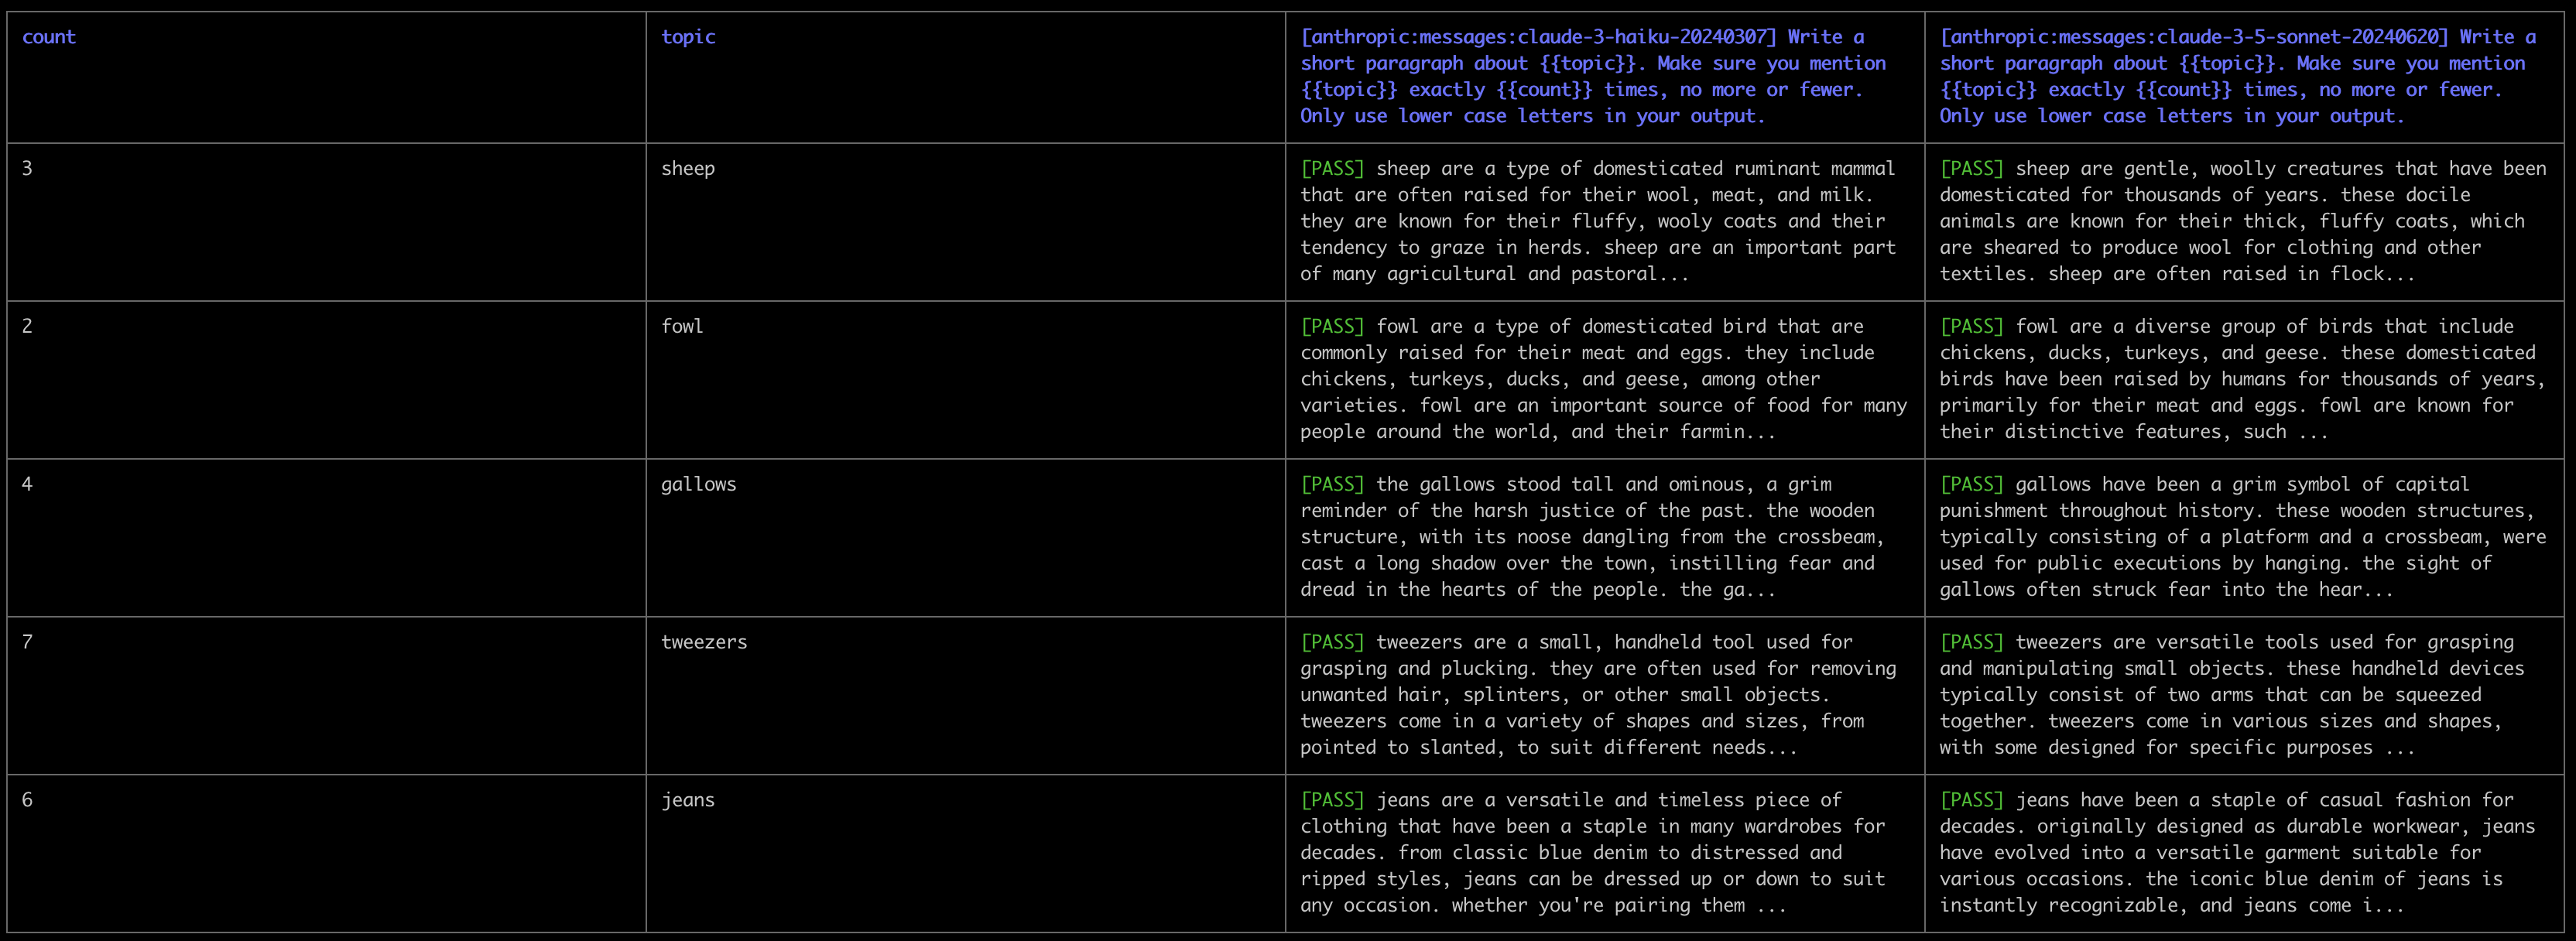

If we zoom in on a single row, we can see the model outputs generally look good.  In this example, `{{topic}}` was set to "sheep", and corresponding model outputs are paragraphs about sheep!

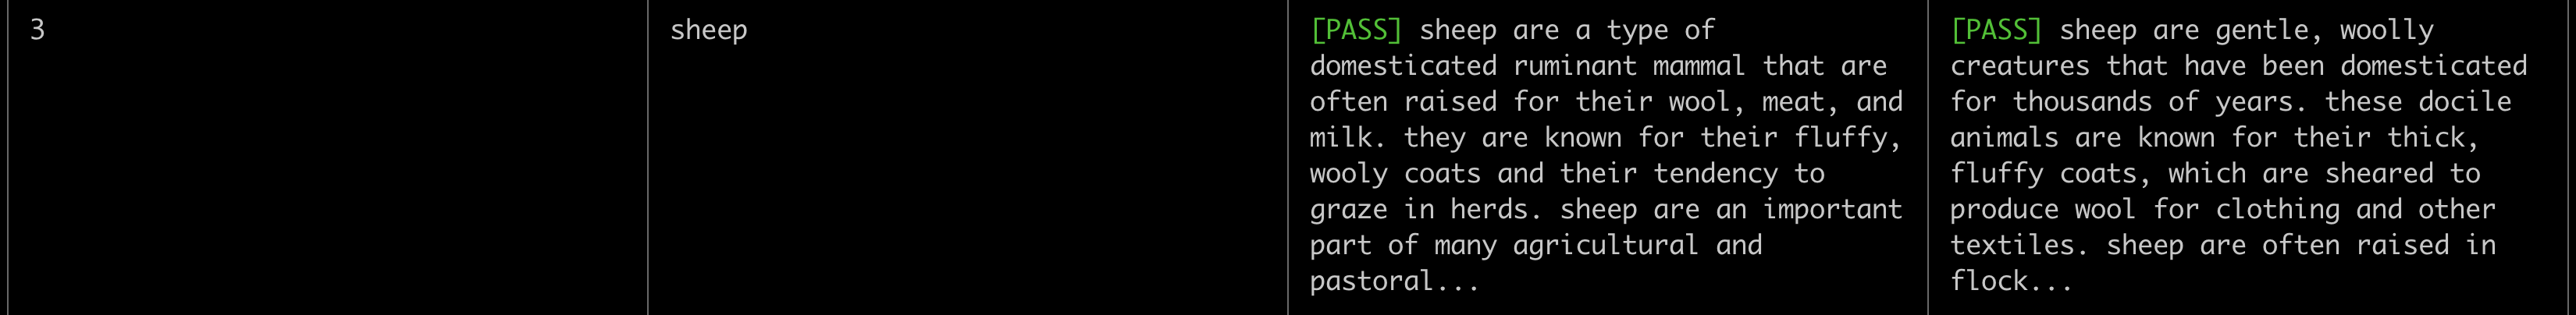

Now we just need to implement our custom grading logic to test whether the outputs mention the topic the correct number of times!

---

## Adding a custom grader function

Promptfoo allows us to define our own Python grader functions.  For this particular example, we want to define a function that ensures the model output mentions the specific topic the correct number of times.  We'll start by defining a new python file called `count.py`.  In this file, we'll add the following function:

```py
import re

def get_assert(output, context):
    topic = context["vars"]["topic"]
    goal_count = int(context["vars"]["count"])
    pattern = fr'(^|\s)\b{re.escape(topic)}\b'

    actual_count = len(re.findall(pattern, output.lower()))

    pass_result = goal_count == actual_count

    result = {
        "pass": pass_result,
        "score": 1 if pass_result else 0,
        "reason": f"Expected {topic} to appear {goal_count} times. Actual: {actual_count}",
    }
    return result
```

Let's talk about what the above code does.  Promptfoo will automatically look for a function named `get_assert` in our file.  It will pass the function two arguments:

- The output from a given model
- The `context` dictionary that includes the variables and prompt that generated the output

Promptfoo expects our function to return one of the following:
- a bool (pass/fail)
- a float (score)
- a GradingResult dictionary

We've opted to return a GradingResult dictionary, which must include the following properties:

- `pass_`: boolean
-  `score`: float
- `reason`: a string explanation

In the above function, we extract the topic and count from the `context` parameter and then use a regular expression to count the number of times the topic occurs in the output, before returning `result`

Now that we've defined our grader, it's time to tell promptfoo about it.  Update the `promptfooconfig.yaml` file:

```yaml
description: Count mentions
prompts:
  - >-
    Write a short paragraph about {{topic}}. Make sure you mention {{topic}} exactly {{count}} times, no more or fewer. Only use lower case letters in your output.
providers:
  - anthropic:messages:claude-3-haiku-20240307
  - anthropic:messages:claude-3-5-sonnet-20240620
defaultTest:
  assert:
    - type: python
      value: file://count.py
tests:
  - vars:
      topic: sheep
      count: 3
  - vars:
      topic: fowl
      count: 2
  - vars:
      topic: gallows
      count: 4
  - vars:
      topic: tweezers
      count: 7
  - vars:
      topic: jeans
      count: 6
```
The `defaultTest` tells promptfoo that for each test that it runs, we want it to use the Python grader we defined in our `count.py` file.

---


## Running the evaluation

To run the evaluation, we'll use the same command we've seen before:

```bash
npx promptfoo@latest eval
```


This is the output we got from running the eval:

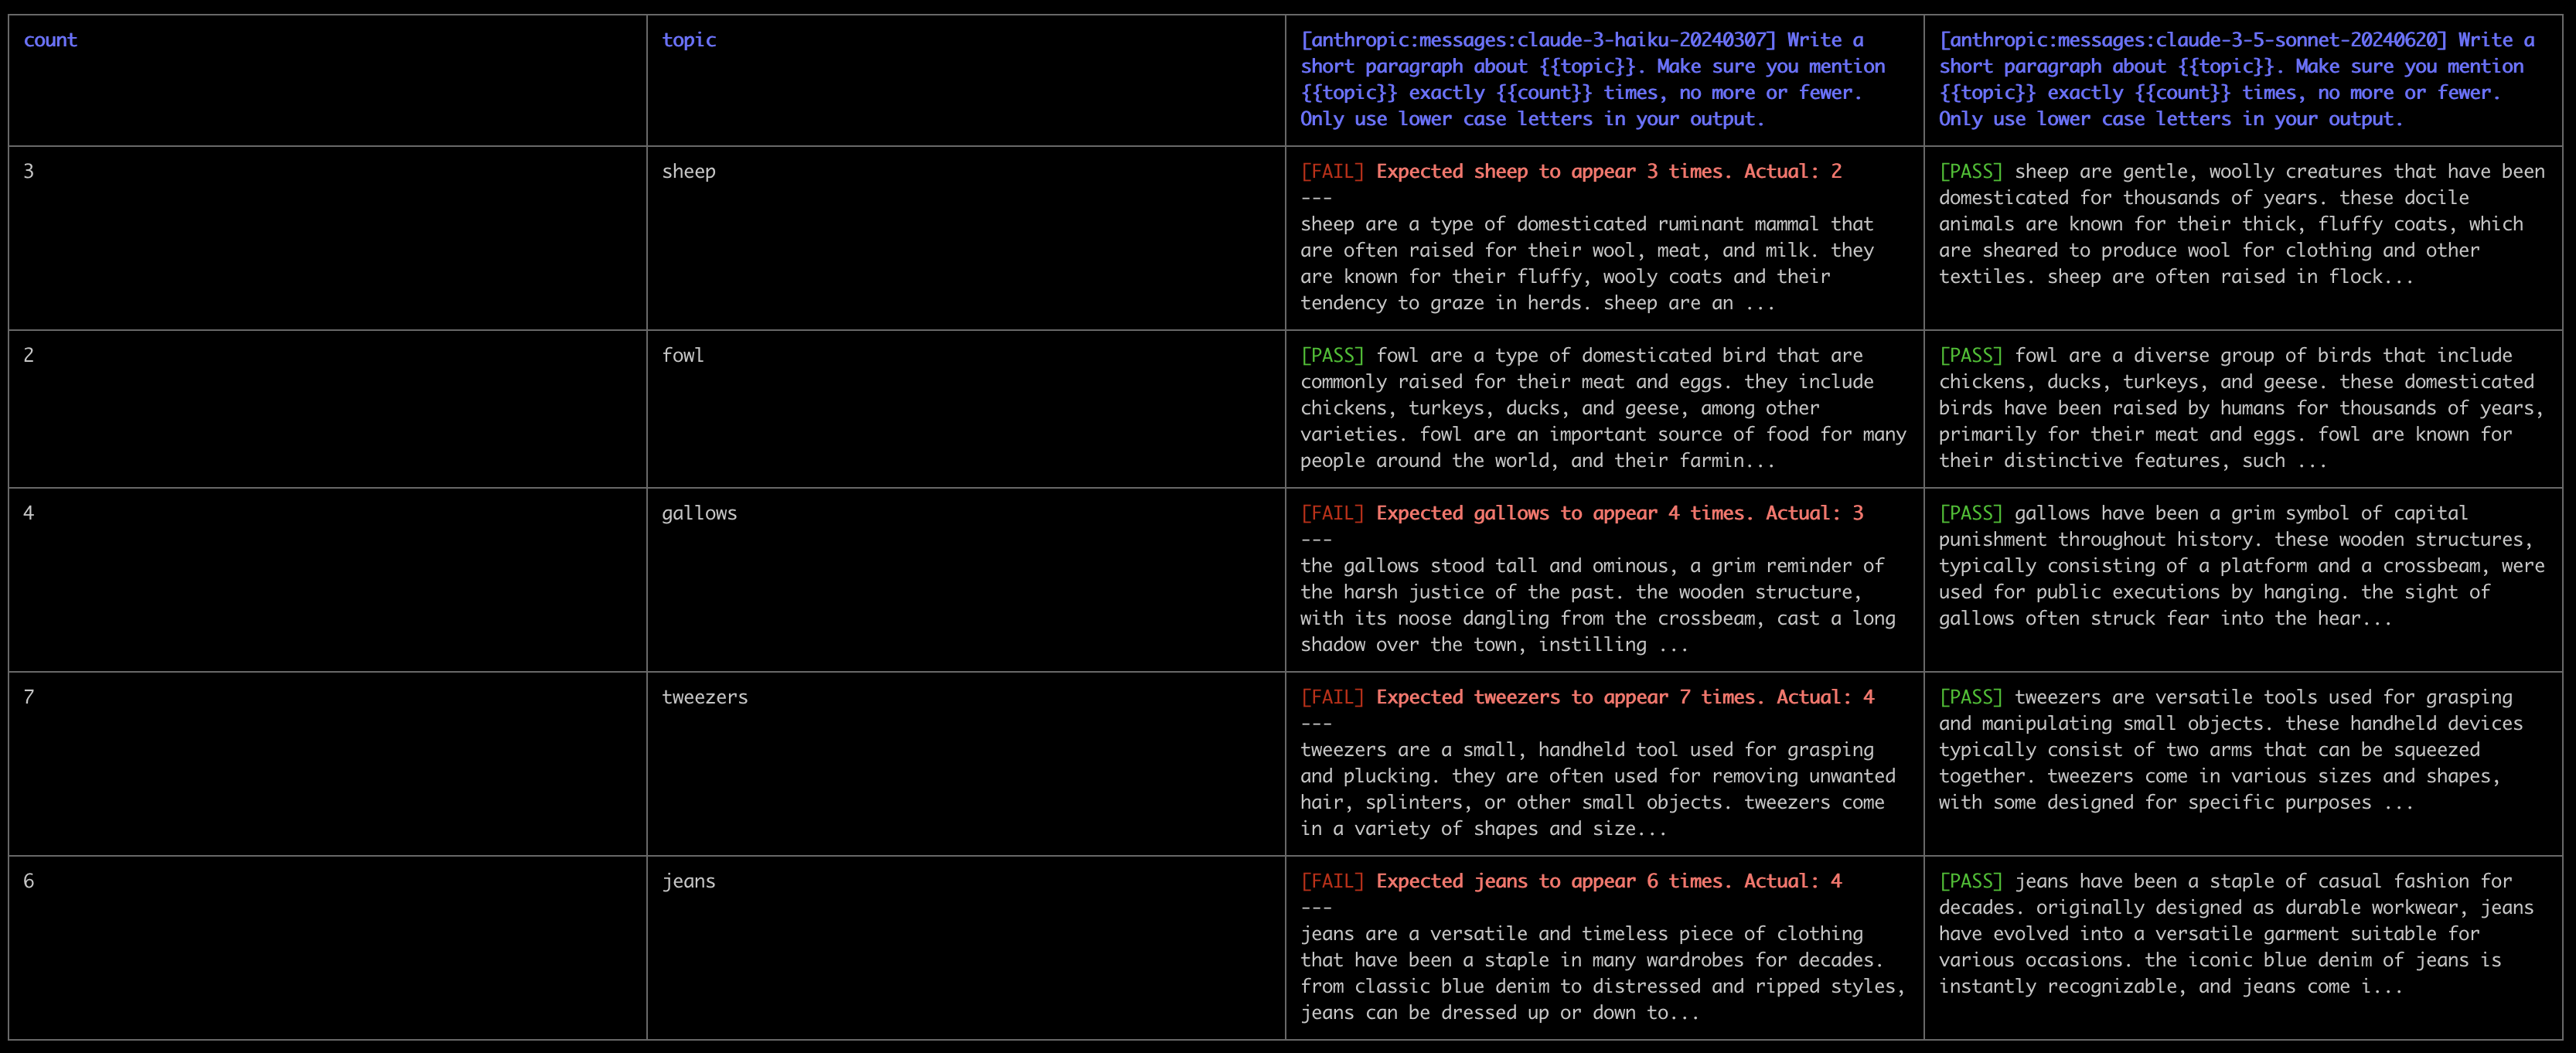

Run this command to launch the web interface: 

```bash
npx promptfoo@latest view
```

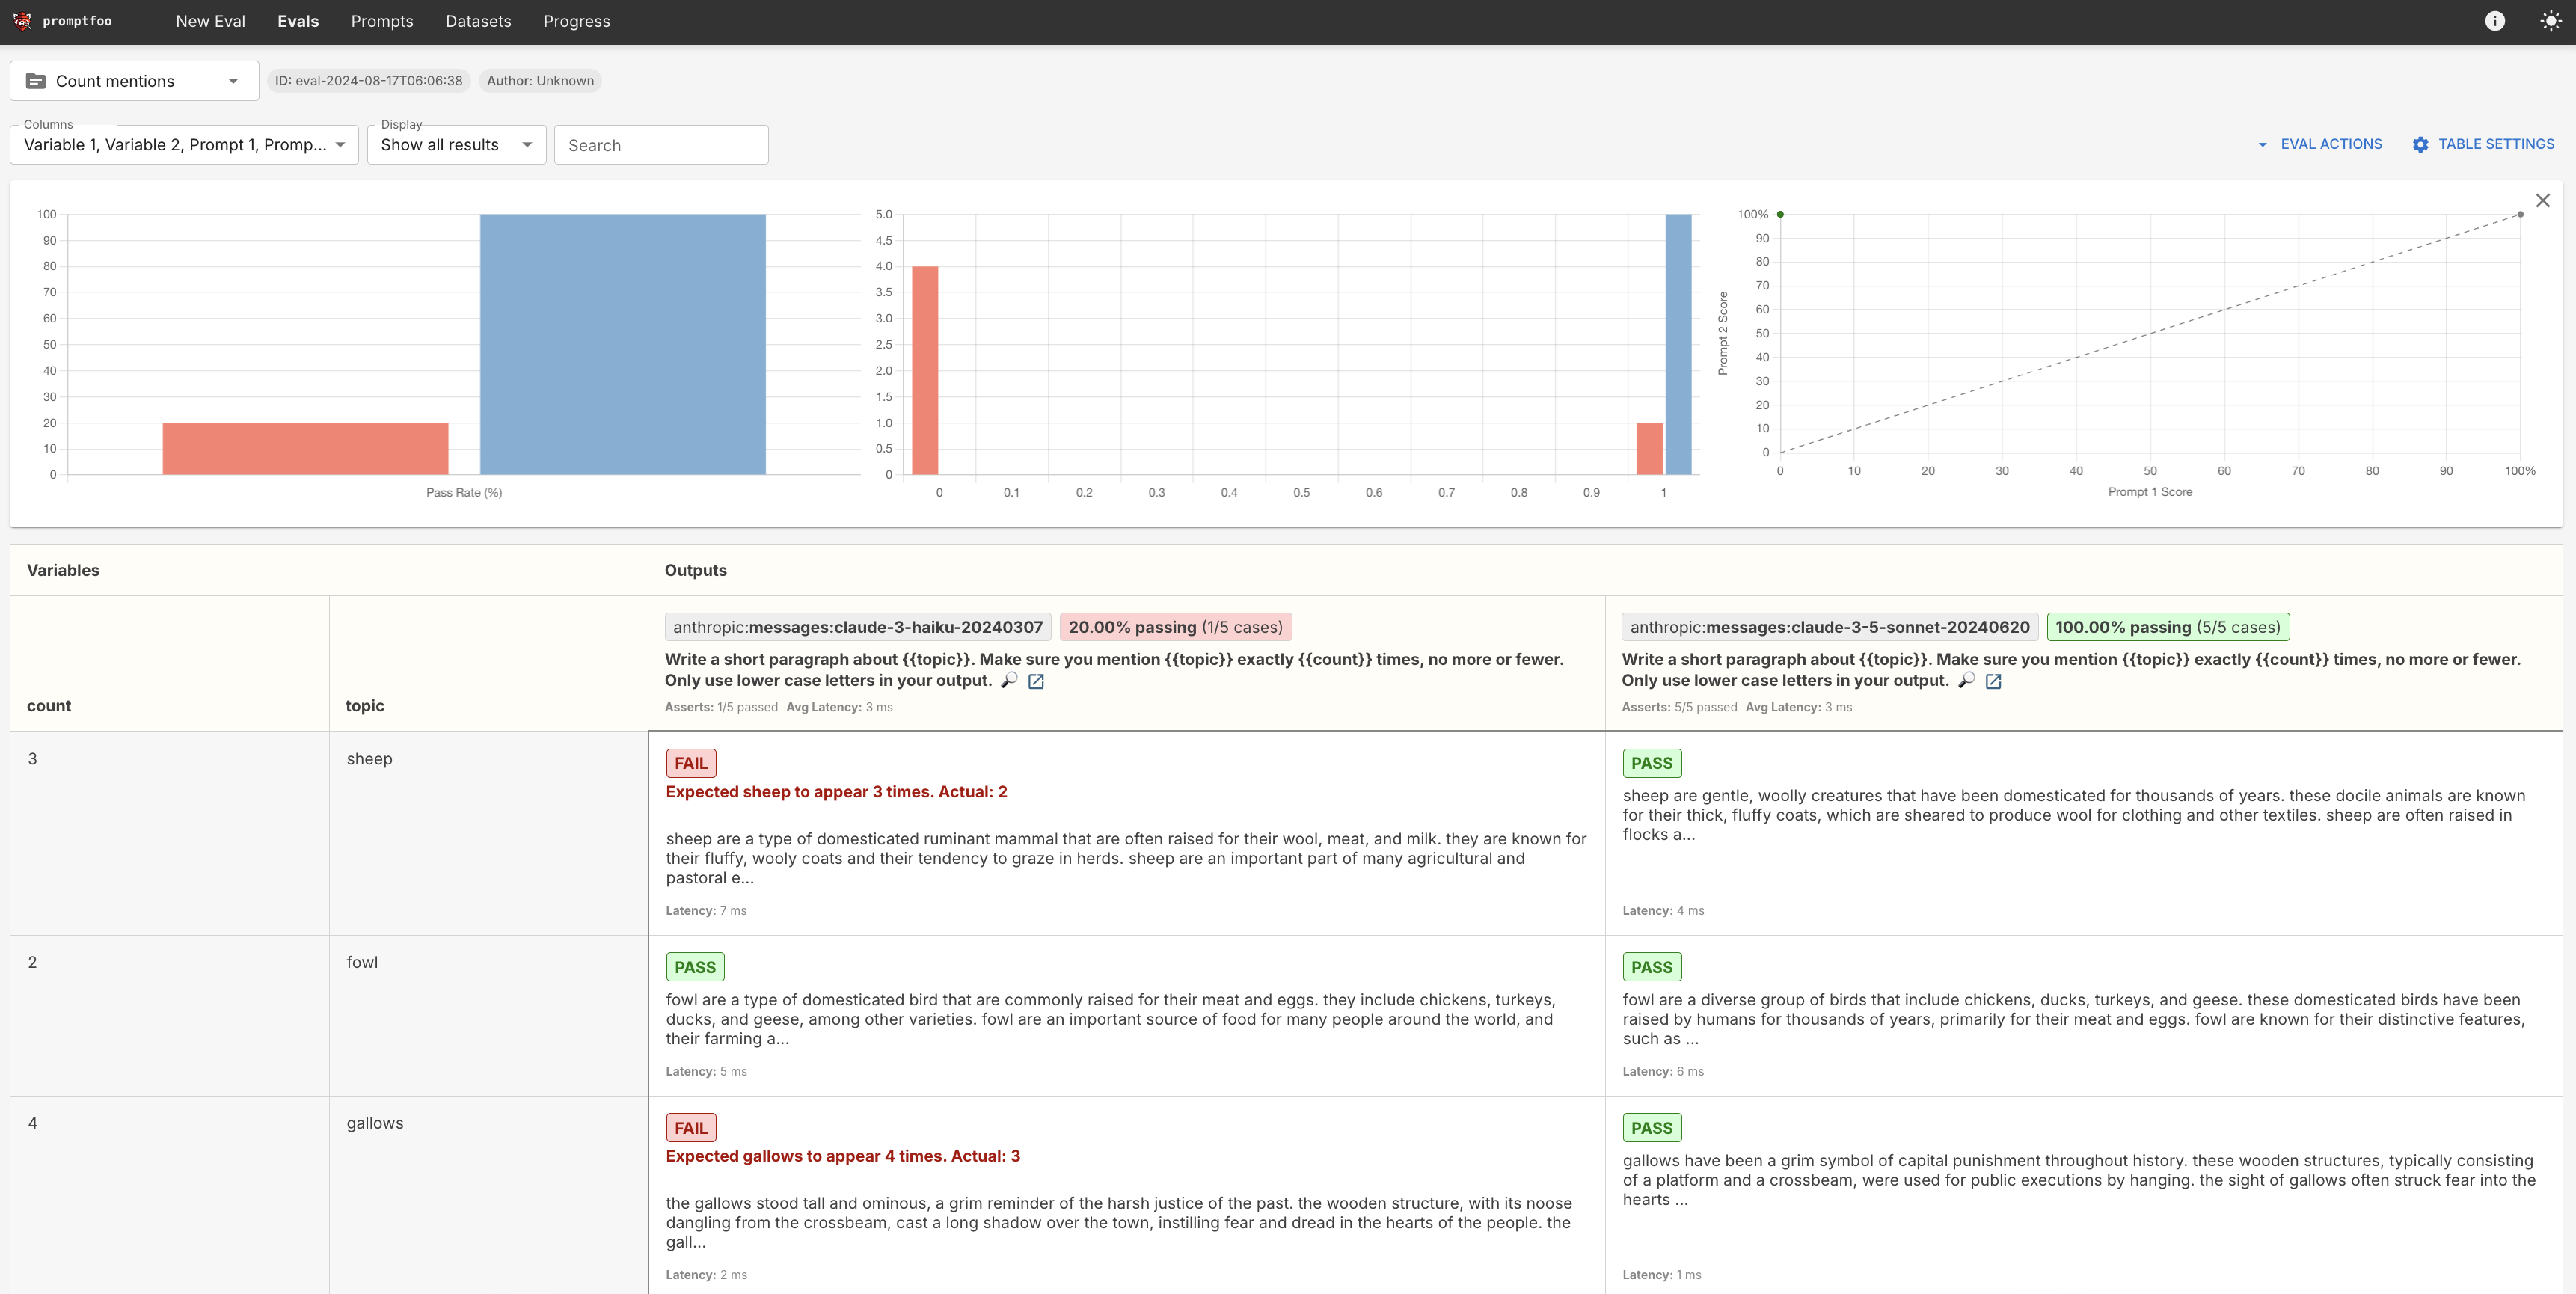

We can see that Claude 3.5 scored 100% while Claude 3 Haiku scored 20% on this task.  To verify the results, click the magnifying glass icon to see the full input prompt and corresponding output. 

Here's the incorrect output for Claude 3 Haiku: 

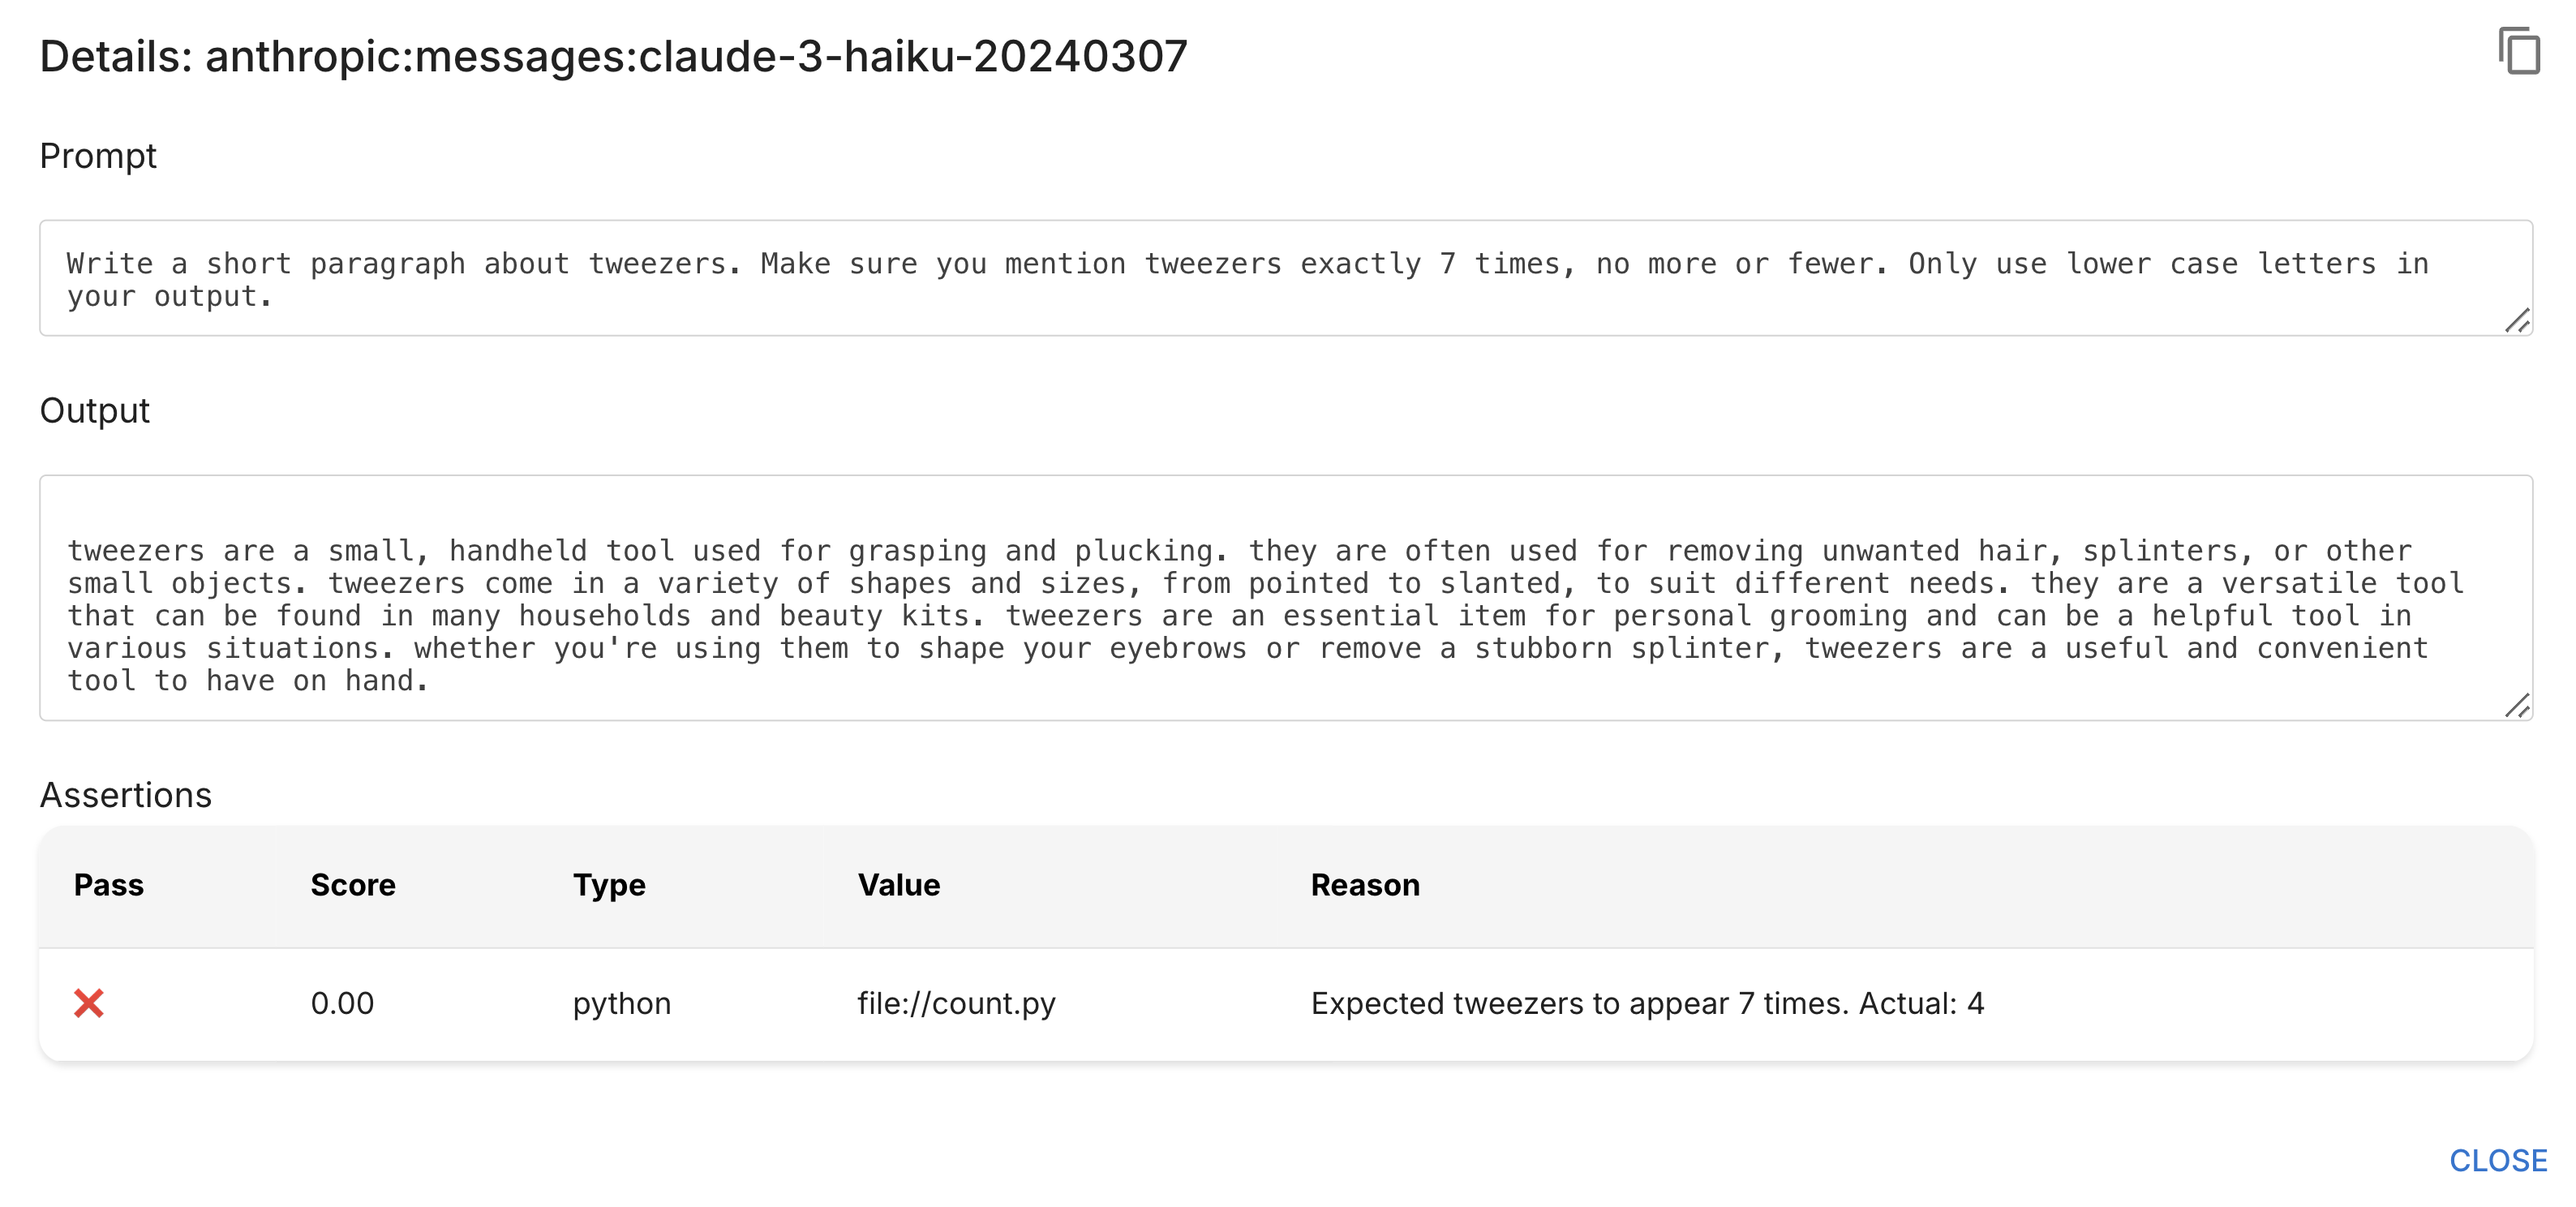

And the correct output for Claude 3.5 Sonnet:

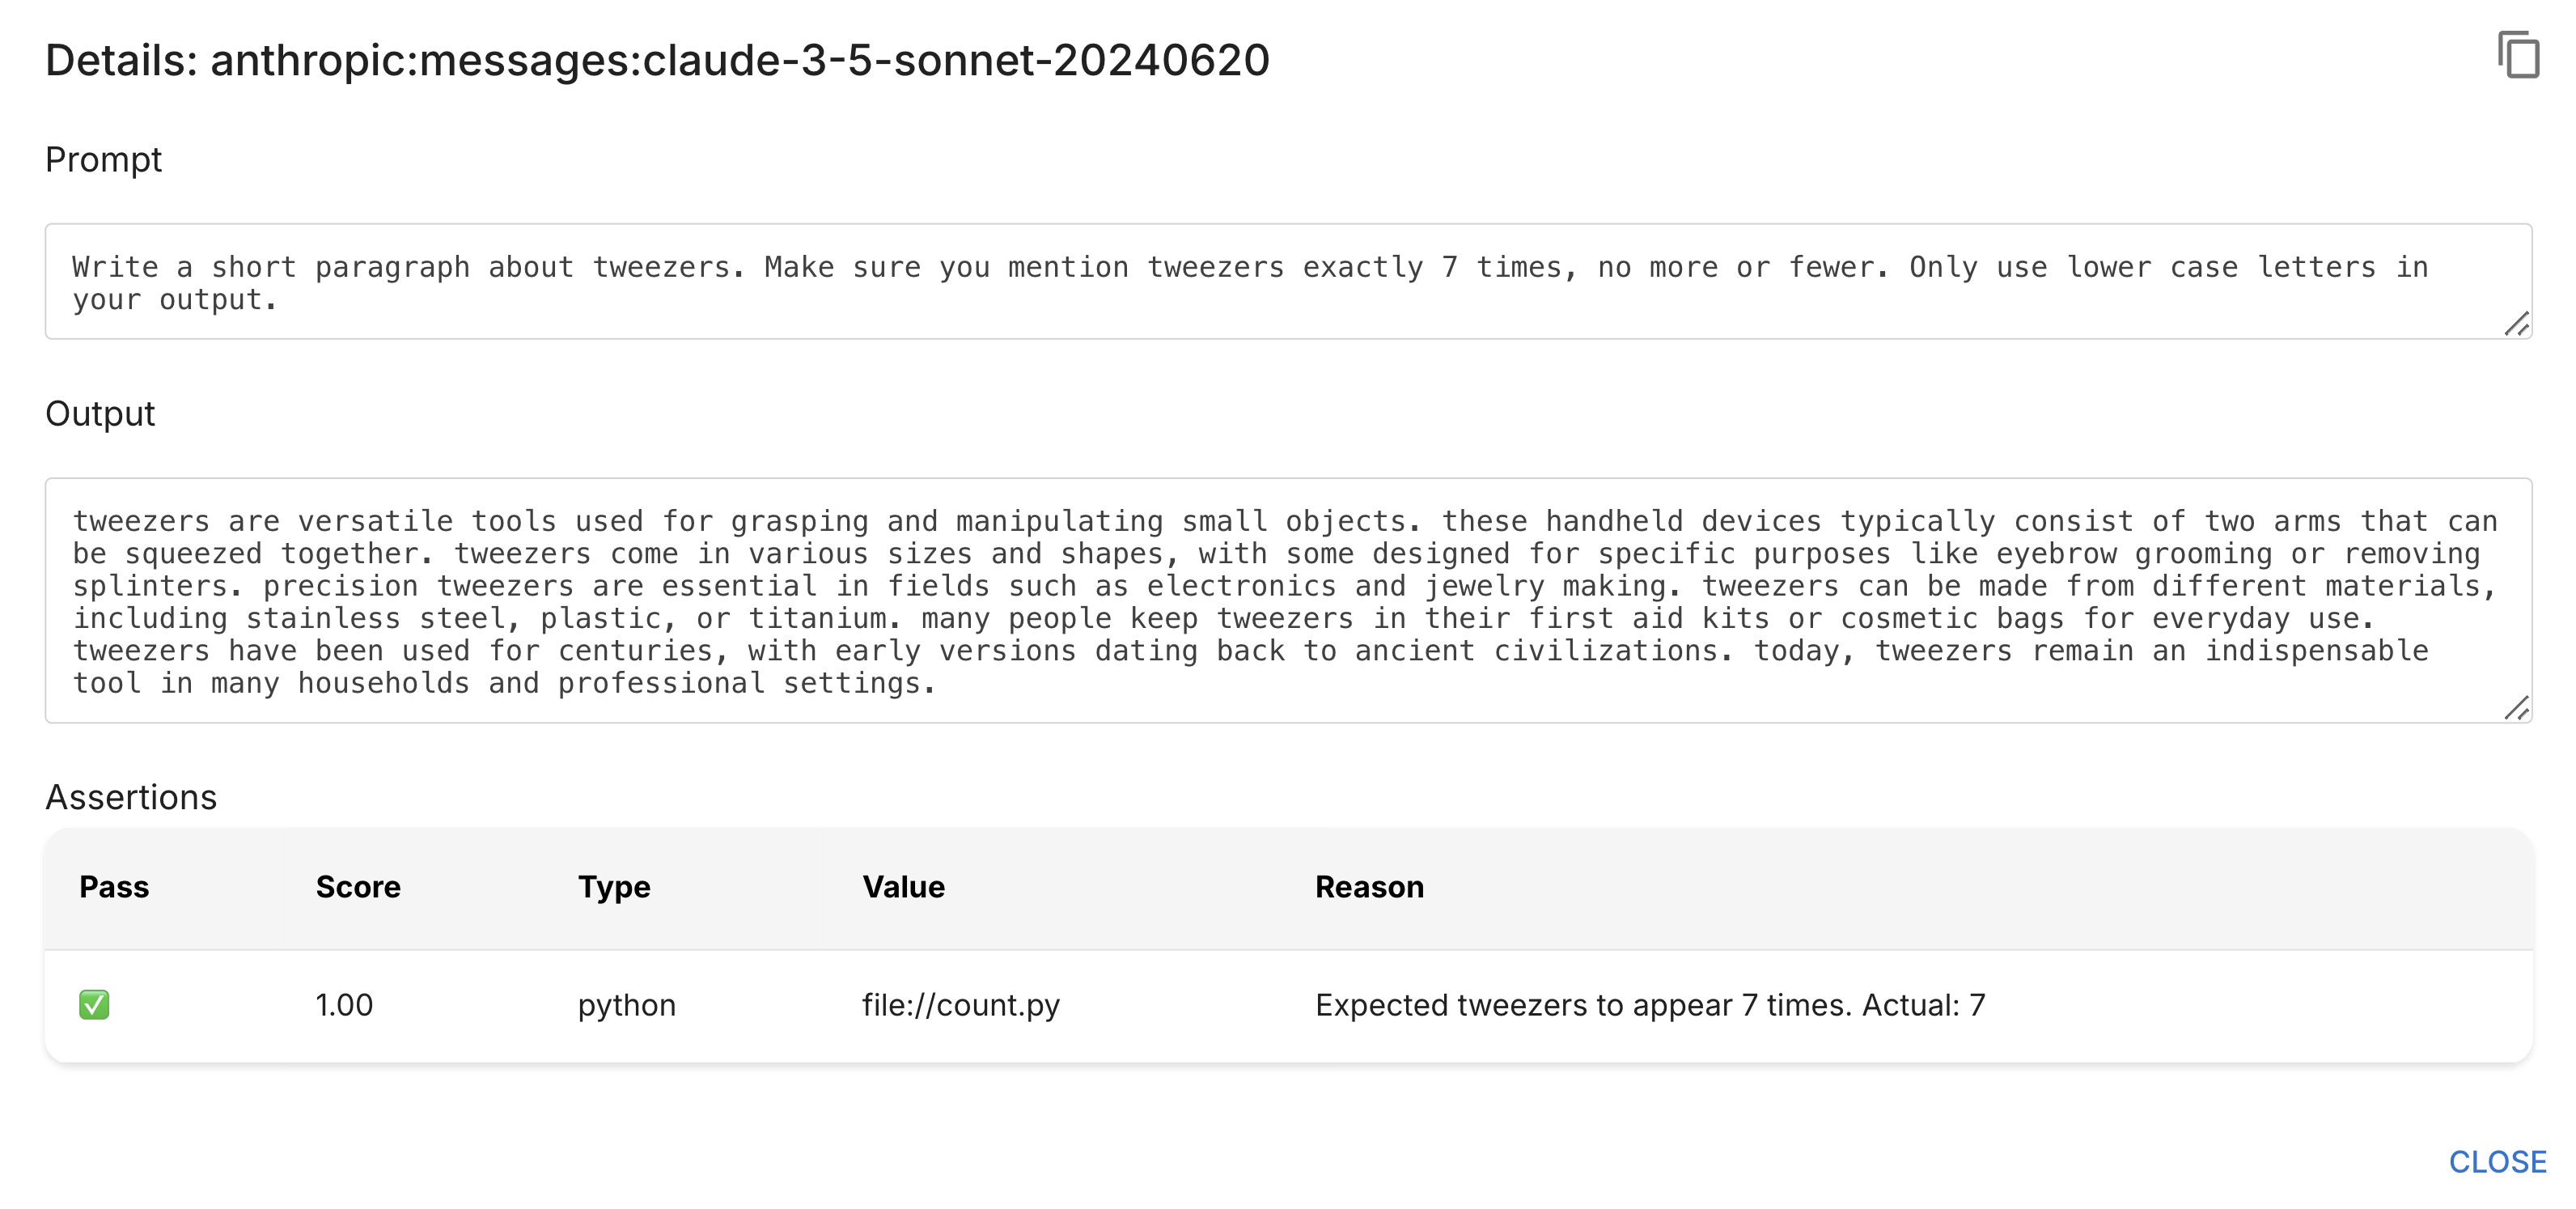

This specific evaluation is a little silly, but it's meant to demonstrate the process of defining custom Python grader logic. Between the built-in promptfoo assertions and customer grader-functions, we can write virtually any code-graded evaluation.

In the next lesson, we'll learn about model-graded evaluations in promptfoo.